In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import configparser

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import shap
from sklearn.ensemble import RandomForestRegressor
#import sys
#https://builtin.com/data-science/outlier-detection-python
#https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137


: 

In [3]:
a = [1,2,3,4,5]
b = [0,0,2,4]

ix = a.copy()
c = 0

for e in a:
    if e in b:
        ix[c] = 1.0
    else:
        ix[c] = 0.0
    c = c + 1

{2, 4}

In [2]:
SEED = 17
TRAIN_SIZE = 400000
TEST_SIZE = 61043
BALANCE_DATA = True

In [3]:
root = ''
df = pd.read_csv(root + '../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_Network_dataset/Train_Test_Network.csv')

In [4]:
df.shape

(461043, 45)

In [5]:
cat_indexs = [0, 1, 2, 3, 4, 5, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41]
num_indexs = [6, 7, 8, 10, 11, 12, 13, 14, 33, 34]

In [6]:
df_sub = df.sample(TRAIN_SIZE + TEST_SIZE, random_state=SEED, replace=False)

In [7]:
type = df_sub.pop('type')
ts = df_sub.pop('ts')
lbls = df_sub.pop('label')


In [8]:
df_num = df_sub.iloc[:,num_indexs]

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(df, lbls, test_size=0.33, random_state=SEED)

In [10]:
X_train = df_sub[:TRAIN_SIZE]
X_test = df_sub[TRAIN_SIZE:]
y_train = lbls[:TRAIN_SIZE]
y_test = lbls[TRAIN_SIZE:]

In [11]:
df_num_train = X_train.iloc[:,num_indexs]
df_num_test = X_test.iloc[:,num_indexs]
#df_cat = df.iloc[:, cat_indexs]

## Outlier detection

In [12]:
def boxplot(column, in_data):
    sns.boxplot(data=in_data,x=in_data[f"{column}"])
    plt.title(f"Boxplot of netwrk num features {column}")
    plt.show()

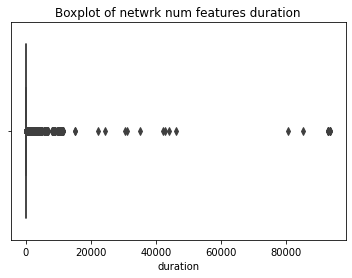

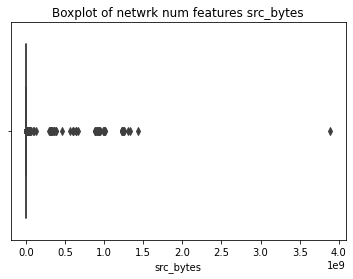

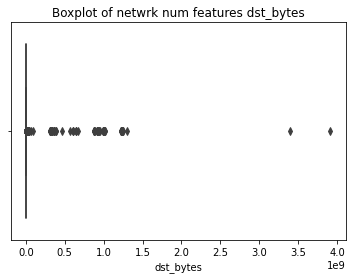

In [13]:
boxplot('duration', df_num)
boxplot('src_bytes', df_num)
boxplot('dst_bytes', df_num)
# boxplot('missed_bytes', df_num)
#...

### Isolation Forests

In [14]:
# FALTA METER TS TYPE Y LABEL A LA HORA DE GUARDAR

In [15]:
# clf = IsolationForest(random_state=0)
# clf.fit(df_num_train)
# y_pred = clf.predict(df_num_test)
# 
# pred = pd.DataFrame({'pred': y_pred})
# 
# pred['y_pred'] = np.where(pred['pred'] == -1, 1, 0)
# y_pred = pred['y_pred'] 
# print("Precision:", precision_score(y_test, y_pred))

In [16]:
clf = IsolationForest(random_state=0)
clf.fit(df_num)
preds = np.where(clf.predict(df_num) == -1, 1, 0)

In [17]:
clean_df = df_sub[~preds.astype(bool)]

In [18]:
clean_df['type'] = type[~preds.astype(bool)].values.copy()
clean_df['ts'] = ts[~preds.astype(bool)].values.copy()
clean_df['label'] = lbls[~preds.astype(bool)].values.copy()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


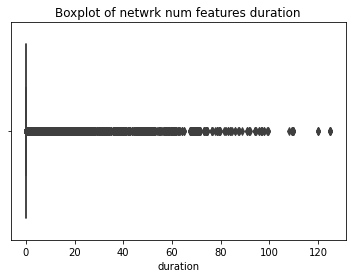

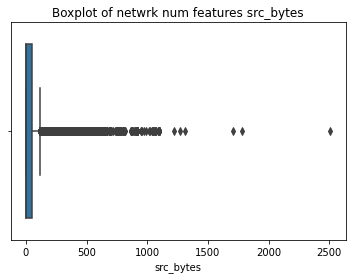

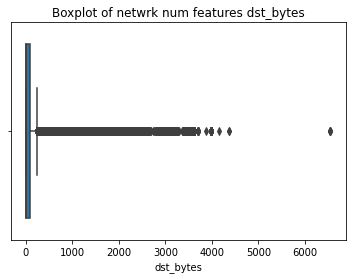

In [19]:
boxplot('duration', clean_df)
boxplot('src_bytes', clean_df)
boxplot('dst_bytes', clean_df)

In [ ]:
clean_df.to_csv(root + '../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_Network_dataset/isol_forest_prep.csv') 

### One class classification SVM

In [ ]:
# clf_svm = OneClassSVM(gamma='auto')
# clf_svm.fit(df_num_train)
# y_pred_svm = clf_svm.predict(df_num_test)
# 
# pred = pd.DataFrame()
# 
# pred['svm'] = y_pred_svm
# pred['svm_pred'] = np.where(pred['svm'] == -1, 1, 0)
# 
# y_pred_svm = pred['svm_pred']
# print("SVM Precision:", precision_score(y_test, y_pred_svm))

In [20]:
clf_svm = OneClassSVM(gamma='auto')
clf_svm.fit(df_num)
preds_svm = np.where(clf_svm.predict(df_num) == -1, 1, 0)

In [21]:
clean_df = df_sub[~preds_svm.astype(bool)]

In [22]:
clean_df['type'] = type[~preds_svm.astype(bool)].values.copy()
clean_df['ts'] = ts[~preds_svm.astype(bool)].values.copy()
clean_df['label'] = lbls[~preds_svm.astype(bool)].values.copy()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


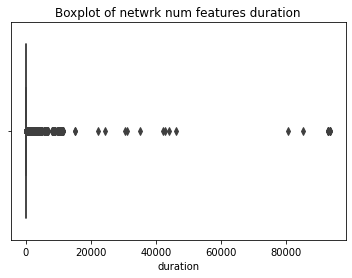

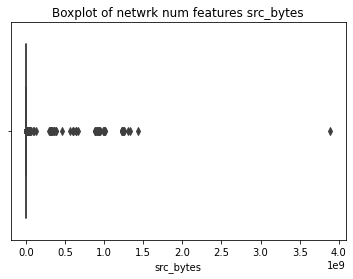

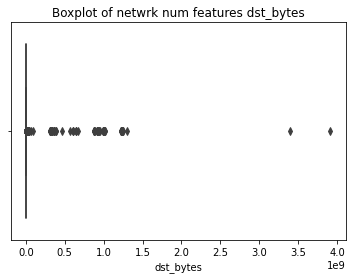

In [23]:
boxplot('duration', df_num)
boxplot('src_bytes', df_num)
boxplot('dst_bytes', df_num)
#boxplot('missed_bytes', df_num)
#...

In [27]:
clean_df.to_csv(root + '../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_Network_dataset/svm_one_class_prep.csv')

## Shap values

In [29]:
cd = clean_df.copy()

In [30]:
# Balanced?
print(len(lbls[lbls==1])/len(lbls))

0.34930147513355586


In [26]:
if BALANCE_DATA:
    num_anom = len(cd.loc[cd['label']==1])
    df_anom = cd.loc[cd['label']==1]
    df_balance = cd.loc[cd['label']==0]
    df_balance = df_balance.sample(num_anom, replace=False, random_state = SEED)
    df_concated = pd.concat([df_balance, df_anom])
    balanced_data = df_concated
    cd = balanced_data

ValueError: Cannot take a larger sample than population when 'replace=False'

In [31]:
cd.pop('type')
cd.pop('ts')
lbls = cd.pop('label')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(cd, lbls, test_size=0.33, random_state=SEED)

In [33]:
df_num_train = X_train.iloc[:,num_indexs]
df_num_test = X_test.iloc[:,num_indexs]

In [34]:
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()# Fits the model on the data
model.fit(df_num_train, y_train)

RandomForestRegressor()

In [35]:
# Fits the explainer
explainer = shap.Explainer(model.predict, df_num_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(df_num_test)
#shap_values = explainer.shap_values(df_num_test)

Exact explainer: 42771it [21:58, 32.43it/s]                           


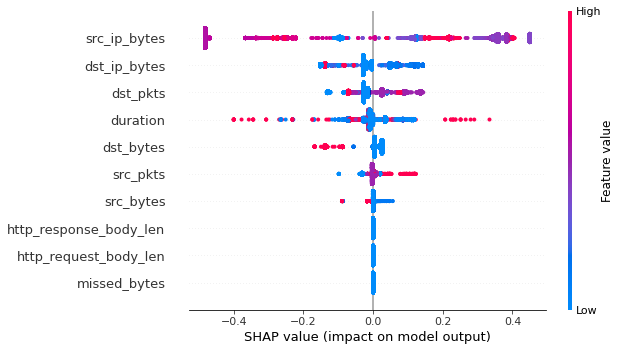

In [36]:
shap.plots.beeswarm(shap_values)